In [52]:
# -*- coding: utf-8 -*-
"""
Annotations reader
Raphaël Ceré
Python 3.6.5
"""

__author__ = "Raphael Cere"
__copyright__ = "Copyright 2019, University of Lausanne, Switzerland"
__credits__ = ["Raphael Cere"]
__license__ = "GNU GPLv3"
__version__ = "0.1a0"
__maintainer__ = "Raphael Cere"
__email__ = "Raphael.Cere@unil.ch"
__status__ = "Development"


def get_data(path):
	"""
	retrun path of data
	"""
	return os.path.dirname(os.path.abspath(path))+"/ANNOTATION_ANT/"

def ann_reader(file):
	"""
	return a list of annotation dictionnaries
	"""
	try:
		with open(file, 'r') as csv_file:
			r_reader = csv.reader(csv_file, delimiter=',')
			h = r_reader.__next__()
			d = list()
			for r in r_reader:
				o = dict()
				[o.update({h[x] : r[x]}) for x in range(0, len(r))]
				d.append(o)
		return d, h
	except IOError: raise IOError("Couldn't read file %s" % file)

def pb_inter(bp0, bp1, head, padding1=0., padding2=0.):
	"""
	retrun True if intersect 
	"""
	pl1, pl2, al = [head[8], head[9]], [head[10], head[11]], head[3]
	if bp0[al] == "point" and bp1[al] == "box":
		x0, y0 = (float(bp0[pl1[0]]), float(bp0[pl1[1]]))
		x1, y1, x2, y2 = (float(bp1[pl1[0]]), float(bp1[pl1[1]]), float(bp1[pl2[0]]),float(bp1[pl2[1]]))
		return True if (x1-padding1 <= x0 <= x2+padding1) and (y1-padding1 <= y0 <= y2+padding1) else False
	elif bp0[al] == "box" and bp1[al] == "box":
		x01, y01, x02, y02 = (float(bp0[pl1[0]]), float(bp0[pl1[1]]), float(bp0[pl2[0]]),float(bp0[pl2[1]]))
		x11, y11, x22, y22 = (float(bp1[pl1[0]]), float(bp1[pl1[1]]), float(bp1[pl2[0]]),float(bp1[pl2[0]]))
		down = True if (x01-padding1 <= x11-padding2 <= x02+padding1) and (y01-padding1 <= y11-padding2 <= y02+padding1) else False
		up = True if (x01-padding1 <= x22+padding2 <= x02+padding1) and (y01-padding1 <= y22+padding2 <= y02+padding1) else False
		return True if down and up else False

def get_annotation(file, inter=False):
	"""
	retrun dictionnary by object from database
	file : path to the file
	inter : keep only annotation intersecting with one or more R.1
	"""
	if inter:
		a, h = ann_reader(file)
		is_r1 = [x for x in a if x[h[1]] == "R1"] # plusieur entres similaire !!!
		b = list()
		is_c1_r1 = list()
		if is_r1:
			for p0 in is_r1: [is_c1_r1.append(x) for x in a if pb_inter(p0, x, h) and x[h[1]] != "R1" and x[h[1]] == "C1"]
			for p1 in is_c1_r1: b.append([x[h[1]] for x in a if pb_inter(p1, x, h) and x[h[1]] != "R1" and x[h[1]] != "C1"])
		else: b = []
	else: b, h = ann_reader(file)
	return b,h 


if __name__ == '__main__':
	import os
	import csv
	import json
	import numpy as np
	import itertools
	import networkx as nx
	import matplotlib.pyplot as plt
	from itertools import compress
	%matplotlib notebook
	%matplotlib notebook

	# tmp paramters
	#tmp_path =  "/Users/rcere/switchdrive/ddd_cvmm/DATA/ANNOTATION_ANT"
	tmp_path = str(input("PATH OF ANNOTATION:"))

PATH OF ANNOTATION:/Users/rcere/switchdrive/ddd_cvmm/DATA/ANNOTATION_ANT


In [53]:
	# Read annotations
	BASE_PATH  = get_data(tmp_path)
	annotation_drawings = list() 
	annotation_drawings_id = list()
	for annotation in [x for x in os.listdir(BASE_PATH) if x[:10]=="annotation"]:
		drawing = get_annotation(BASE_PATH+annotation, True)
		annotation_drawings.append((annotation, drawing[0]))


	ann_by_god = [x[0] for x in [y[1] for y in annotation_drawings if y[1]] if x[0]]
	id_by_god  = [y[0] for y in annotation_drawings if y[1] and [y[0]]*len(y[1][0])]
	g = len(ann_by_god)
	n = len(annotation_drawings)

	print(">>> %s gods identified for %s drawings <<< p = %f" %(g,n, float(g/n)))

>>> 493 gods identified for 745 drawings <<< p = 0.661745


In [54]:
	# unique items present ########
	items_by_gods = list()
	for i in ann_by_god: [items_by_gods.append(x) for x in i] 
	items_unique = list(set(items_by_gods)) # headers
	h = len(items_unique)

	print(">>> %s unique caracteristics." %(h))
	print(items_unique)

>>> 22 unique caracteristics.
['A5.3.2', 'A6.3', 'A4.3', 'A2.1.2', 'A1.2.6.1', 'A3.7', 'A4.1', 'A1.4', 'A1.2.6.2', 'A3.2', 'C5', 'A6.4', 'A2.1.3', 'A3.4', 'A2.1.1', 'A1.6', 'A1.2.1', 'A5.3.4', 'A6.2', 'C3', 'A2.4.3', 'C2']


In [55]:
	# gods x items ########
	count_items_by_god = np.zeros((g,0))
	for i in items_unique:
		a = [j.count(i) for j in ann_by_god]
		count_items_by_god = np.hstack((count_items_by_god,np.array(a)[:,np.newaxis]))

	rows = np.array(id_by_god , dtype='|S'+str(np.max([len(x) for x in id_by_god])))[:, np.newaxis]
	data = np.char.mod("%10.0f", count_items_by_god)
	with open('god_x_items_count.csv', 'w') as f:
		np.savetxt(f, np.hstack((rows, data)), delimiter=', ', fmt='%s', header=str(items_unique))
    
	print(np.shape(data))
	print("Example output: ")
	print(np.hstack((rows, data))[np.random.randint(g),:])

(493, 22)
Example output: 
['annotation_ch10_ge_m_rbc_13_09_ant-r_677_960_csv_export_karlen_carine'
 '         0' '         0' '         0' '         0' '         0'
 '         0' '         0' '         2' '         0' '         0'
 '         0' '         0' '         0' '         0' '         0'
 '         2' '         1' '         0' '         0' '         0'
 '         0' '         0']


In [56]:
	binary_items_by_god = np.zeros((g,h))
	binary_items_by_god[np.where(count_items_by_god >=1.)] = 1.
	rows = np.array(id_by_god , dtype='|S'+str(np.max([len(x) for x in id_by_god])))[:, np.newaxis]
	data = np.char.mod("%10.0f", binary_items_by_god)
	with open('god_x_items_binary.csv', 'w') as f:
		np.savetxt(f, np.hstack((rows, data)), delimiter=', ', fmt='%s', header=str(items_unique))

	print(np.shape(data))
	print("Example output: ")
	print(np.hstack((rows, data))[np.random.randint(g),:])

(493, 22)
Example output: 
['annotation_ch16_vd_m_rld_11_01_kai-r_677_960_csv_export_christine_rodier'
 '         0' '         0' '         0' '         0' '         1'
 '         0' '         0' '         1' '         0' '         0'
 '         0' '         0' '         0' '         0' '         0'
 '         1' '         1' '         0' '         0' '         0'
 '         0' '         0']


In [57]:
	# Ouput 1 expected 
	unq, cnt = np.unique(binary_items_by_god, axis=0, return_counts=True)
	with open('god_x_items_unique.csv', 'w') as f:
		np.savetxt(f, np.hstack((unq, cnt[:, np.newaxis])), delimiter=', ', fmt='%s', header=str(items_unique))

	print(np.shape(unq))
	print("Example output: ")
	print(np.hstack((unq, cnt[:, np.newaxis])))

(58, 22)
Example output: 
[[ 0.  0.  0. ...  0.  0. 10.]
 [ 0.  0.  0. ...  0.  0.  4.]
 [ 0.  0.  0. ...  0.  0.  5.]
 ...
 [ 0.  0.  1. ...  0.  0.  1.]
 [ 0.  1.  0. ...  0.  1.  1.]
 [ 1.  0.  0. ...  0.  0.  1.]]


In [58]:
	# items x items ########
	count_by_items = np.zeros((h,h))
	for i in range(h):
		for j in range(h):
			a = [np.sum([x.count(items_unique[i]), x.count(items_unique[j])]) for x in ann_by_god if x.count(items_unique[i]) != 0 and x.count(items_unique[j]) !=0]
			count_by_items[i,j] = np.sum(a)

	rows = np.array(items_unique, dtype='|S'+str(np.max([len(x) for x in items_unique])))[:, np.newaxis]
	data = np.char.mod("%10.0f", count_by_items)
	with open('items_x_items_count.csv', 'w') as f:
		np.savetxt(f,  np.hstack((rows, data)), delimiter=', ', fmt='%s')

	print(np.shape(data))
	print("Example output: ")
	print(np.hstack((rows, data))[np.random.randint(h),:])

(22, 22)
Example output: 
['A2.1.2' '         0' '         0' '         0' '         8' '         8'
 '         0' '         0' '         9' '         0' '         0'
 '         0' '         0' '         2' '         0' '         0'
 '         6' '         8' '         0' '         0' '         0'
 '         0' '         0']


In [59]:
	# -
	binary_by_items = np.zeros((h,h))
	binary_by_items[np.where(count_by_items >=1.)] = 1.
	rows = np.array(items_unique, dtype='|S'+str(np.max([len(x) for x in items_unique])))[:, np.newaxis]
	data = np.char.mod("%10.0f", binary_by_items)
	with open('items_x_items_binary.csv', 'w') as f:
		np.savetxt(f, np.hstack((rows, data)), delimiter=', ', fmt='%s')
    
	print(np.shape(data))
	print("Example output: ")
	print(np.hstack((rows, data))[np.random.randint(h),:])

(22, 22)
Example output: 
['A4.1' '         0' '         0' '         0' '         0' '         1'
 '         0' '         1' '         1' '         0' '         0'
 '         0' '         0' '         0' '         0' '         0'
 '         0' '         1' '         0' '         0' '         0'
 '         0' '         0']


22
[['A1.2.1'], ['A1.6'], ['A1.6', 'A1.2.1'], ['A1.4'], ['A1.4', 'A1.2.1'], ['A1.4', 'A1.2.1', 'C3'], ['A1.4', 'A1.6'], ['A1.4', 'A1.6', 'A1.2.1'], ['A1.4', 'A1.6', 'A1.2.1', 'A2.4.3'], ['A1.4', 'A1.6', 'A1.2.1', 'A5.3.4'], ['A1.4', 'A2.1.1'], ['A1.4', 'A2.1.1', 'A1.2.1'], ['A1.4', 'A2.1.1', 'A1.6'], ['A1.4', 'A2.1.1', 'A1.6', 'A1.2.1'], ['A1.4', 'A3.4', 'A1.2.1', 'A6.2'], ['A1.4', 'A3.4', 'A1.6', 'A1.2.1'], ['A1.4', 'A2.1.3', 'A1.6', 'A1.2.1', 'C3'], ['A1.4', 'A3.2', 'A1.2.1'], ['A1.4', 'A1.2.6.2', 'A1.2.1'], ['A1.4', 'A1.2.6.2', 'A1.6'], ['A1.4', 'A1.2.6.2', 'A1.6', 'A1.2.1'], ['A3.7', 'A1.4', 'A1.2.1']]
[[1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1.]
 [0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0.]
 [1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1.]
 [1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 

<IPython.core.display.Javascript object>


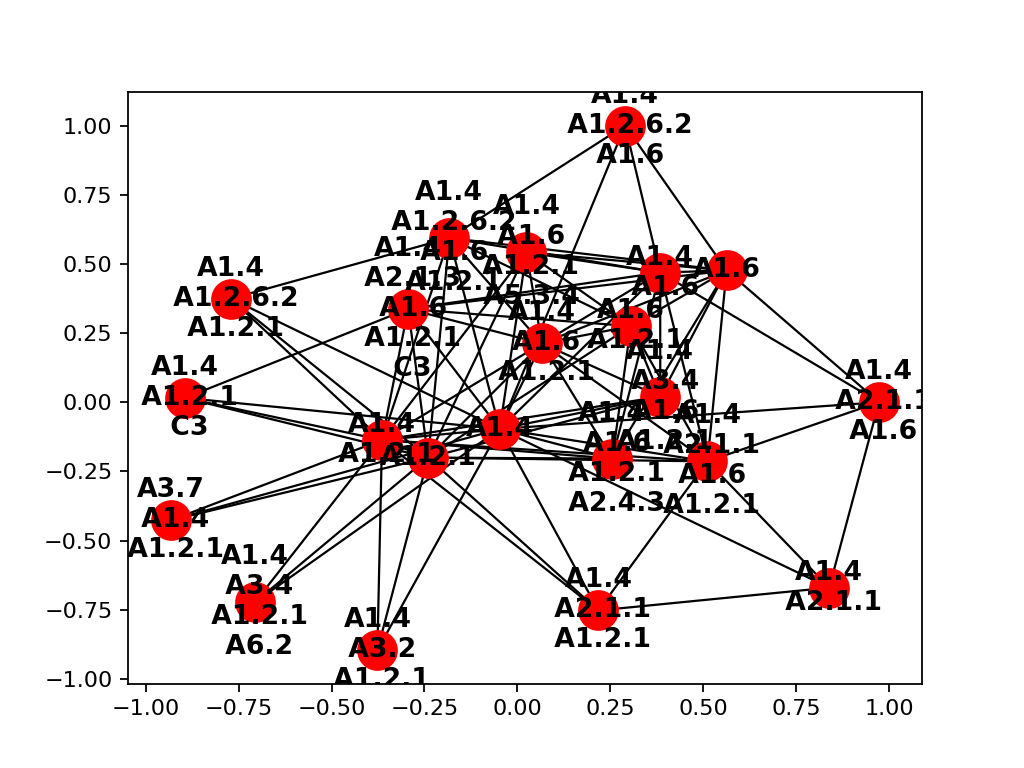

In [60]:
	# All combinaison possible of items ########

	all_comb = list()
	print(len(items_unique))
	for i in range(np.shape(binary_by_items)[0]):
		all_comb.append(list(compress(items_unique, unq[i,:] > 0)))
		#print(items_unique[list(binary_by_items[i,:] > 0)])

	n_comb = len(all_comb)
	net_comb = np.zeros((n_comb, n_comb))
	for i in range(n_comb):
		for j in range(len(all_comb)):
				if len(set(all_comb[i]).intersection(all_comb[j])) == len(all_comb[i]):
					net_comb[i,j] = net_comb[j,i] = 1.
				else: 
					net_comb[i,j] = net_comb[j,i] = net_comb[i,j]
	print(all_comb)
	print(net_comb)
    
	labels = ['\n '.join(map(str, x)) for x in all_comb]
	G = nx.from_numpy_matrix(net_comb)
	G = nx.relabel_nodes(G, dict(zip(range(len(labels)), labels)))
	fig = nx.draw_networkx(G, with_labels=True, font_weight='bold')
	plt.show()

In [61]:
	path_out = str(input("PATH OF OUTPUT:"))
	plt.savefig('network.png', bbox_inches='tight', pad_inches=0, dpi=300)
	assert os.path.isfile(path_out+'network.png'),"Figure note saved. Check the given path."

PATH OF OUTPUT:
